<a href="https://colab.research.google.com/github/magistery-tps/dm-cyt-tp/blob/main/TP_microestados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output
import sys
import os.path
from os import path

def is_localhost(): 
    hostname = !hostname
    return hostname[0] == 'skynet'

# 1. Instalacion de paquetes

Bajo paquete para trabajar con EEG- Me permite ver la topografía

In [3]:
if not is_localhost(): 
    !pip install mne

# 2. Descargar dataset

Se descarga el dataset y lo descomprime en `~/dataset`.

In [4]:
filename     = "procesados-20210908T224817Z-001.zip"
dataset_url  =  f'https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp/main/datasets/{filename}'
dataset_path = "dataset"

if not is_localhost():
    !cd ~
    !rm -rf procesados
    !rm -rf dataset
    !rm -rf {filename}
    !wget  {dataset_url}
    !unzip {filename}
    !mv procesados dataset
    !apt install -y tree
    clear_output()
    !tree dataset

# 3. Importa libreria del proyecto

In [5]:
if not is_localhost():
    if path.exists('/content/dm-cyt-tp'):
        print('Pull...\n')
        !cd dm-cyt-tp; git pull origin main
    else:
        print('Clone...\n')
        !git clone https://github.com/magistery-tps/dm-cyt-tp.git

In [6]:
sys.path.append('./src' if is_localhost() else '/content/dm-cyt-tp/src')

# 4. Importa paquetes externos

In [7]:
import matplotlib.pylab as plt 

import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter

from scipy.signal import find_peaks
from sklearn.cluster import KMeans

from plot import *
from eeg  import get_info_eeg_and_montage, channels

from read_eeg  import load_egg, load_eeg_dataset, to_data_frame

El registro de EEG de 30 canales viene en formato txt (cada uno de los canales es una señal de un electrodo). La frecuencia de muestreo es de 256 Hz.

## 5. Lectura de EEG's

Para cada persona identificada con el número que sigue a "suj_" se hicieron dos registros para cada persona, uno antes de aprender algo "bl_1" y el otro despues de aprender algo "bl_2"

In [8]:
eegs = load_eeg_dataset('./dataset/*')

In [9]:
eegs[0].to_dict()

{'subject': '9',
 'resting_state': '1',
 'nchannels': 30,
 'sfrequency': 128,
 'nsamples': 7681,
 'data': array([[ 1.616  , -0.24897,  2.1471 , ..., -0.22272,  4.0591 , -1.7013 ],
        [-1.4653 , -2.1064 ,  1.8991 , ..., -2.5467 ,  7.479  , -4.1234 ],
        [-3.7501 , -3.2131 ,  0.54613, ..., -3.9687 ,  8.9219 , -5.7996 ],
        ...,
        [-8.728  , -9.0875 , -1.7395 , ..., -5.642  ,  5.1158 , -8.1424 ],
        [-7.7983 , -6.0041 ,  1.8113 , ..., -4.8075 ,  4.5658 , -6.6284 ],
        [-3.9895 , -1.6225 ,  5.0169 , ..., -2.4491 ,  1.9292 , -3.6368 ]])}

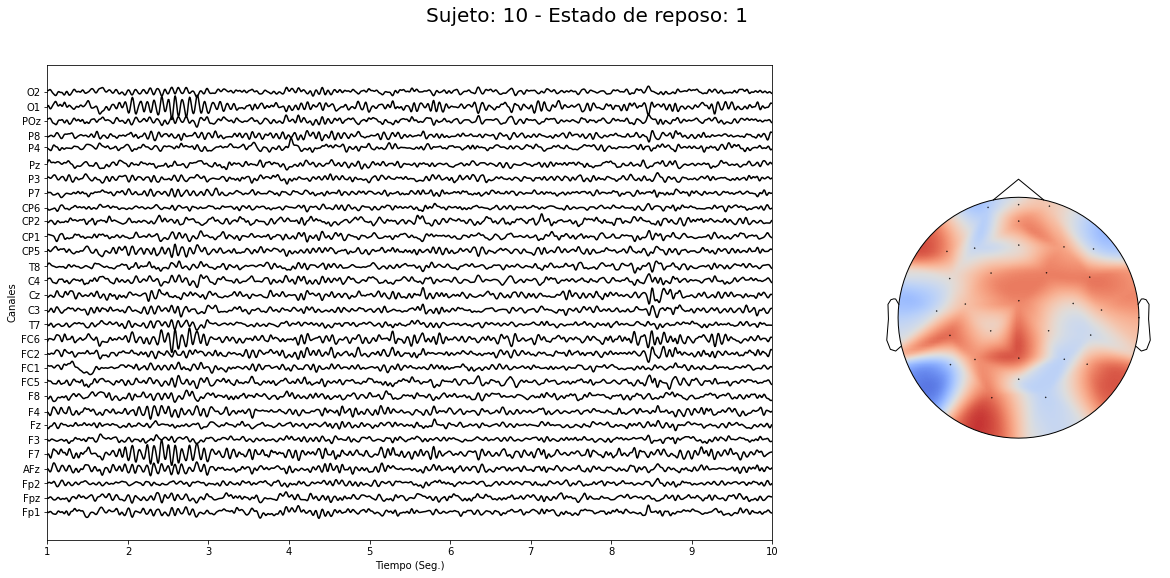

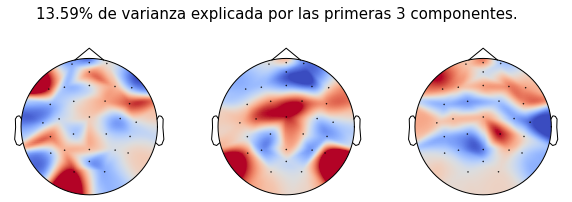

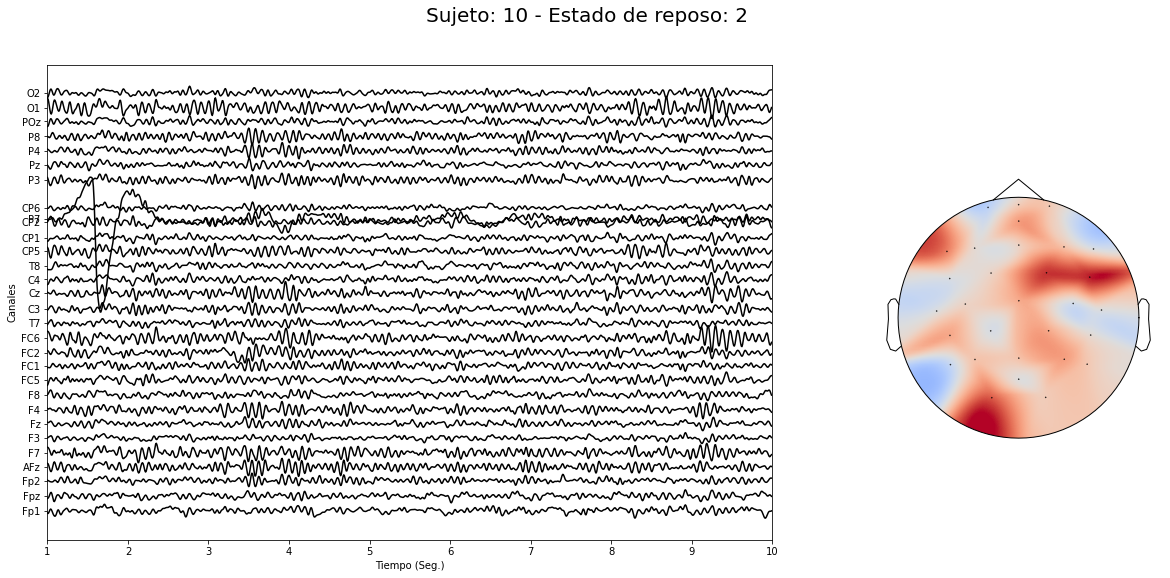

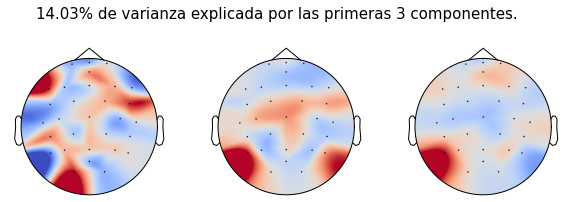

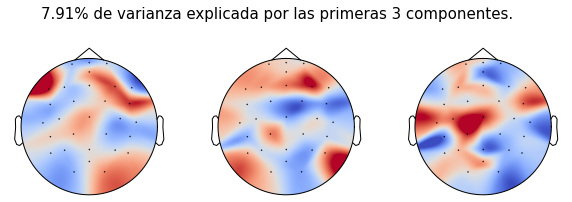

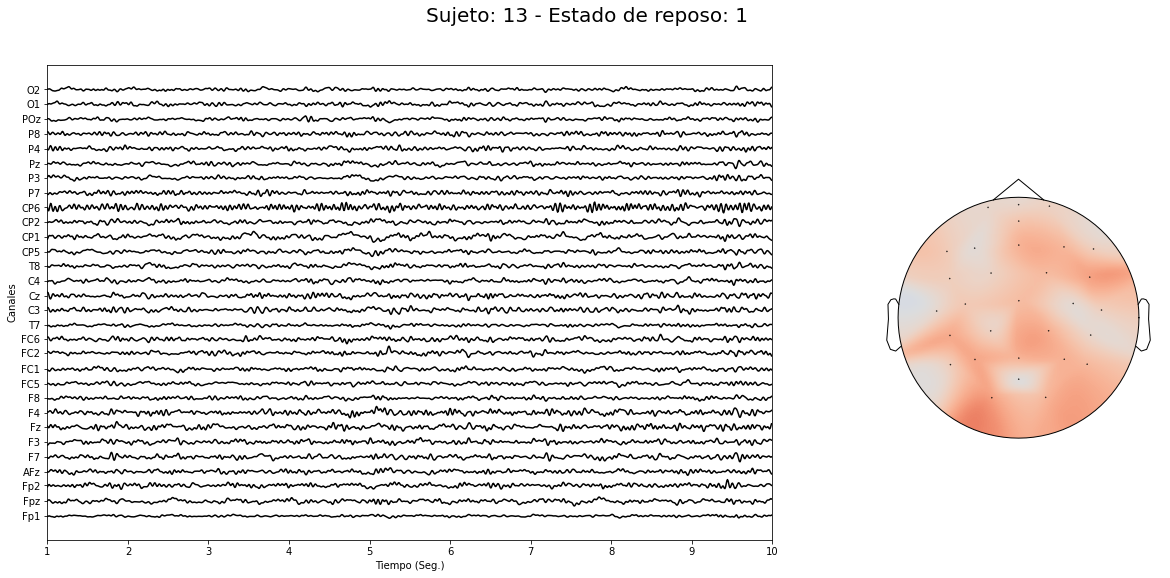

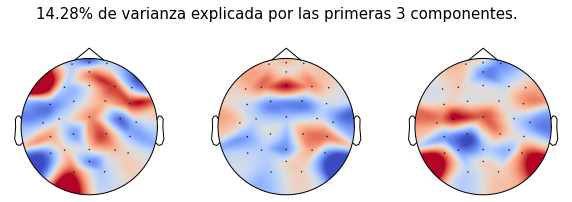

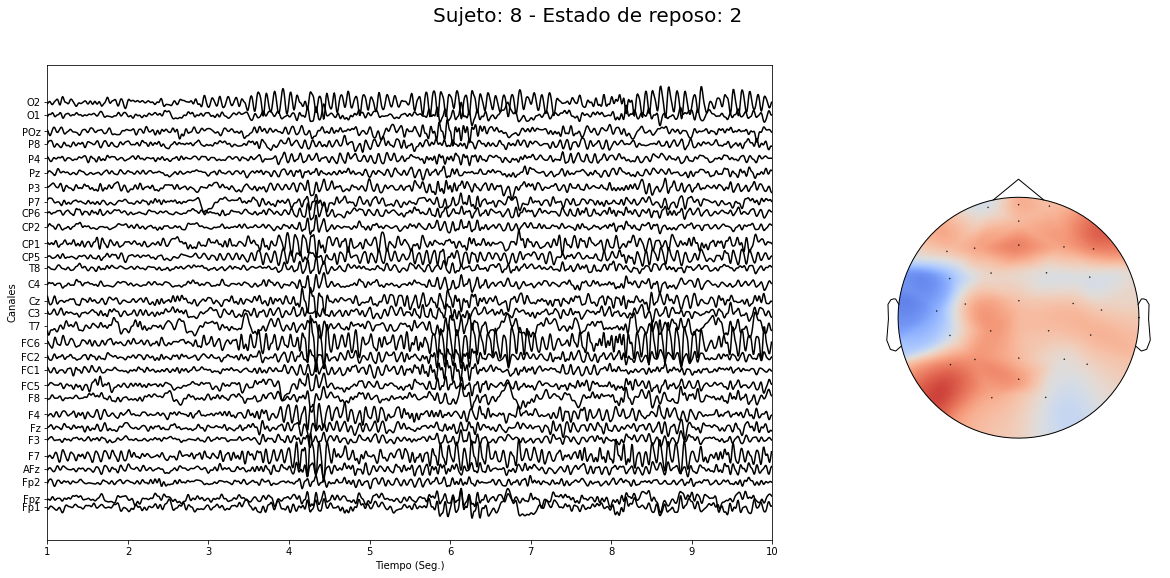

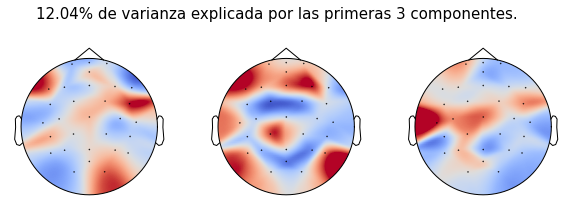

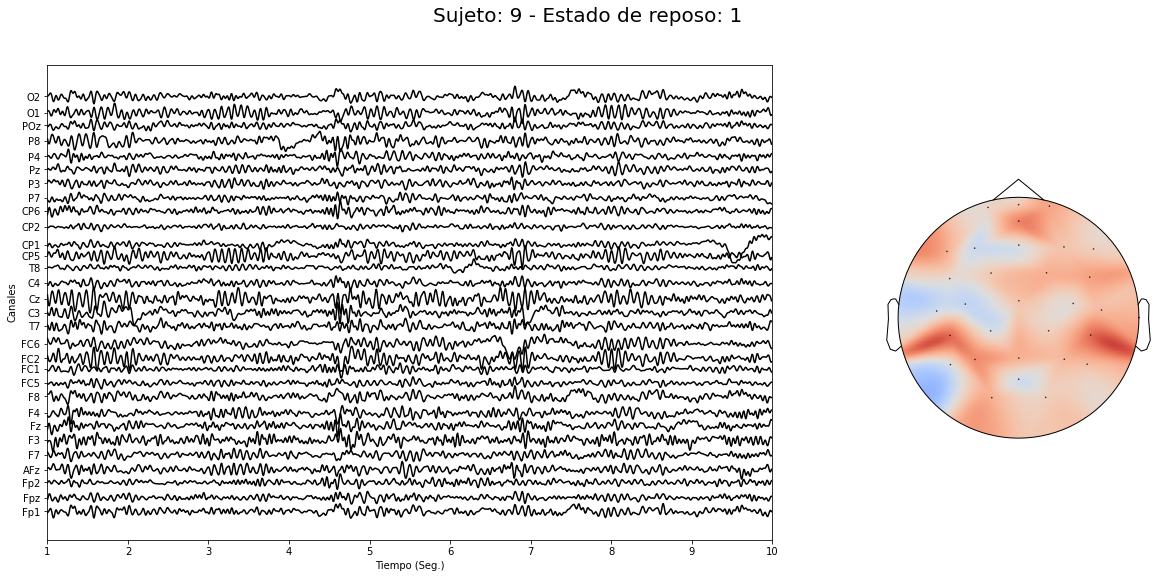

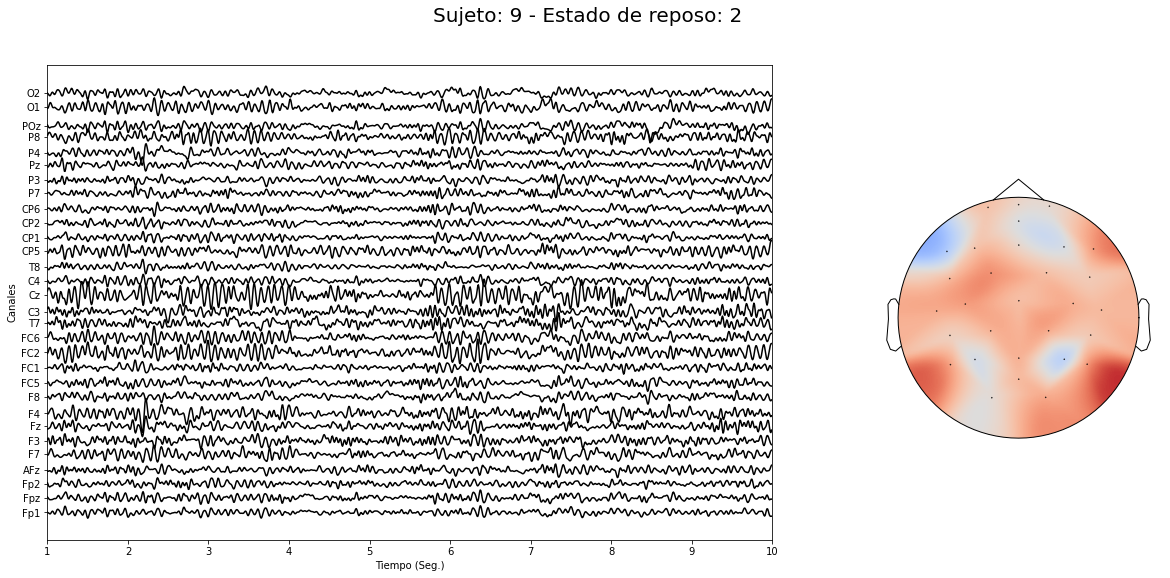

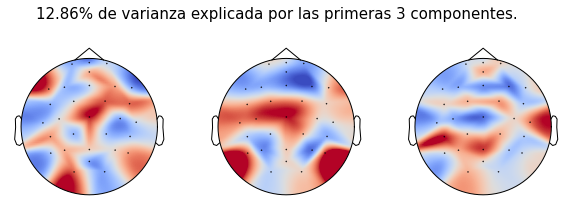

In [119]:
info_eeg, mont1020_30 = get_info_eeg_and_montage()
datos_orig            = np.empty((0,32))  #30 canales + 2 metadata individuo y tipo de reposo
promedios_totales     = np.empty((0,30))
inicio                = 1 #calcula los promedios entre 1 y 4
fin                   = 4

for eeg in sorted(eegs, key=lambda it: it.subject + it.resting_state):
    participante = np.repeat(int(eeg.subject), eeg.nsamples).reshape(eeg.nsamples, 1)
    tipo       = np.repeat(int(eeg.resting_state), eeg.nsamples).reshape(eeg.nsamples, 1)    
    
    metadata   = np.concatenate((participante,tipo),axis=1)
    datos_orig = np.concatenate((datos_orig,np.concatenate((eeg.data, metadata),axis=1)),axis=0)

    promedios         = eeg.data[inicio*eeg.sfrequency:fin*eeg.sfrequency, :].mean(axis=0)
    promedios_totales = np.concatenate((promedios_totales, promedios.reshape(1,30)), axis=0) 

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [3, 1.2]})
    fig.suptitle(f'Sujeto: {eeg.subject} - Estado de reposo: {eeg.resting_state}', size=20, y=1.05)

    plot_egg_on_axis(axes[0], eeg, mont1020_30)
    plot_eeg_topology_on_axis(
        axes[1],
        promedios, 
        info_eeg,
        -0.54932109,  # Estos son los valores máximo y minimo de todos los promedios.
        0.34050091
    )
 
    plot_eeg_pca(info_eeg, eeg)

In [43]:
print(promedios_totales.max(axis=None))
print(promedios_totales.min(axis=None))

0.34050090885416645
-0.5493210911458327


In [44]:
datos_orig.shape

(76810, 32)

Los registros fueron tomados con el montage 10-20.

**La nariz es fpz**.
Tengo que armarlo que los electrodos tengan esta distribución:
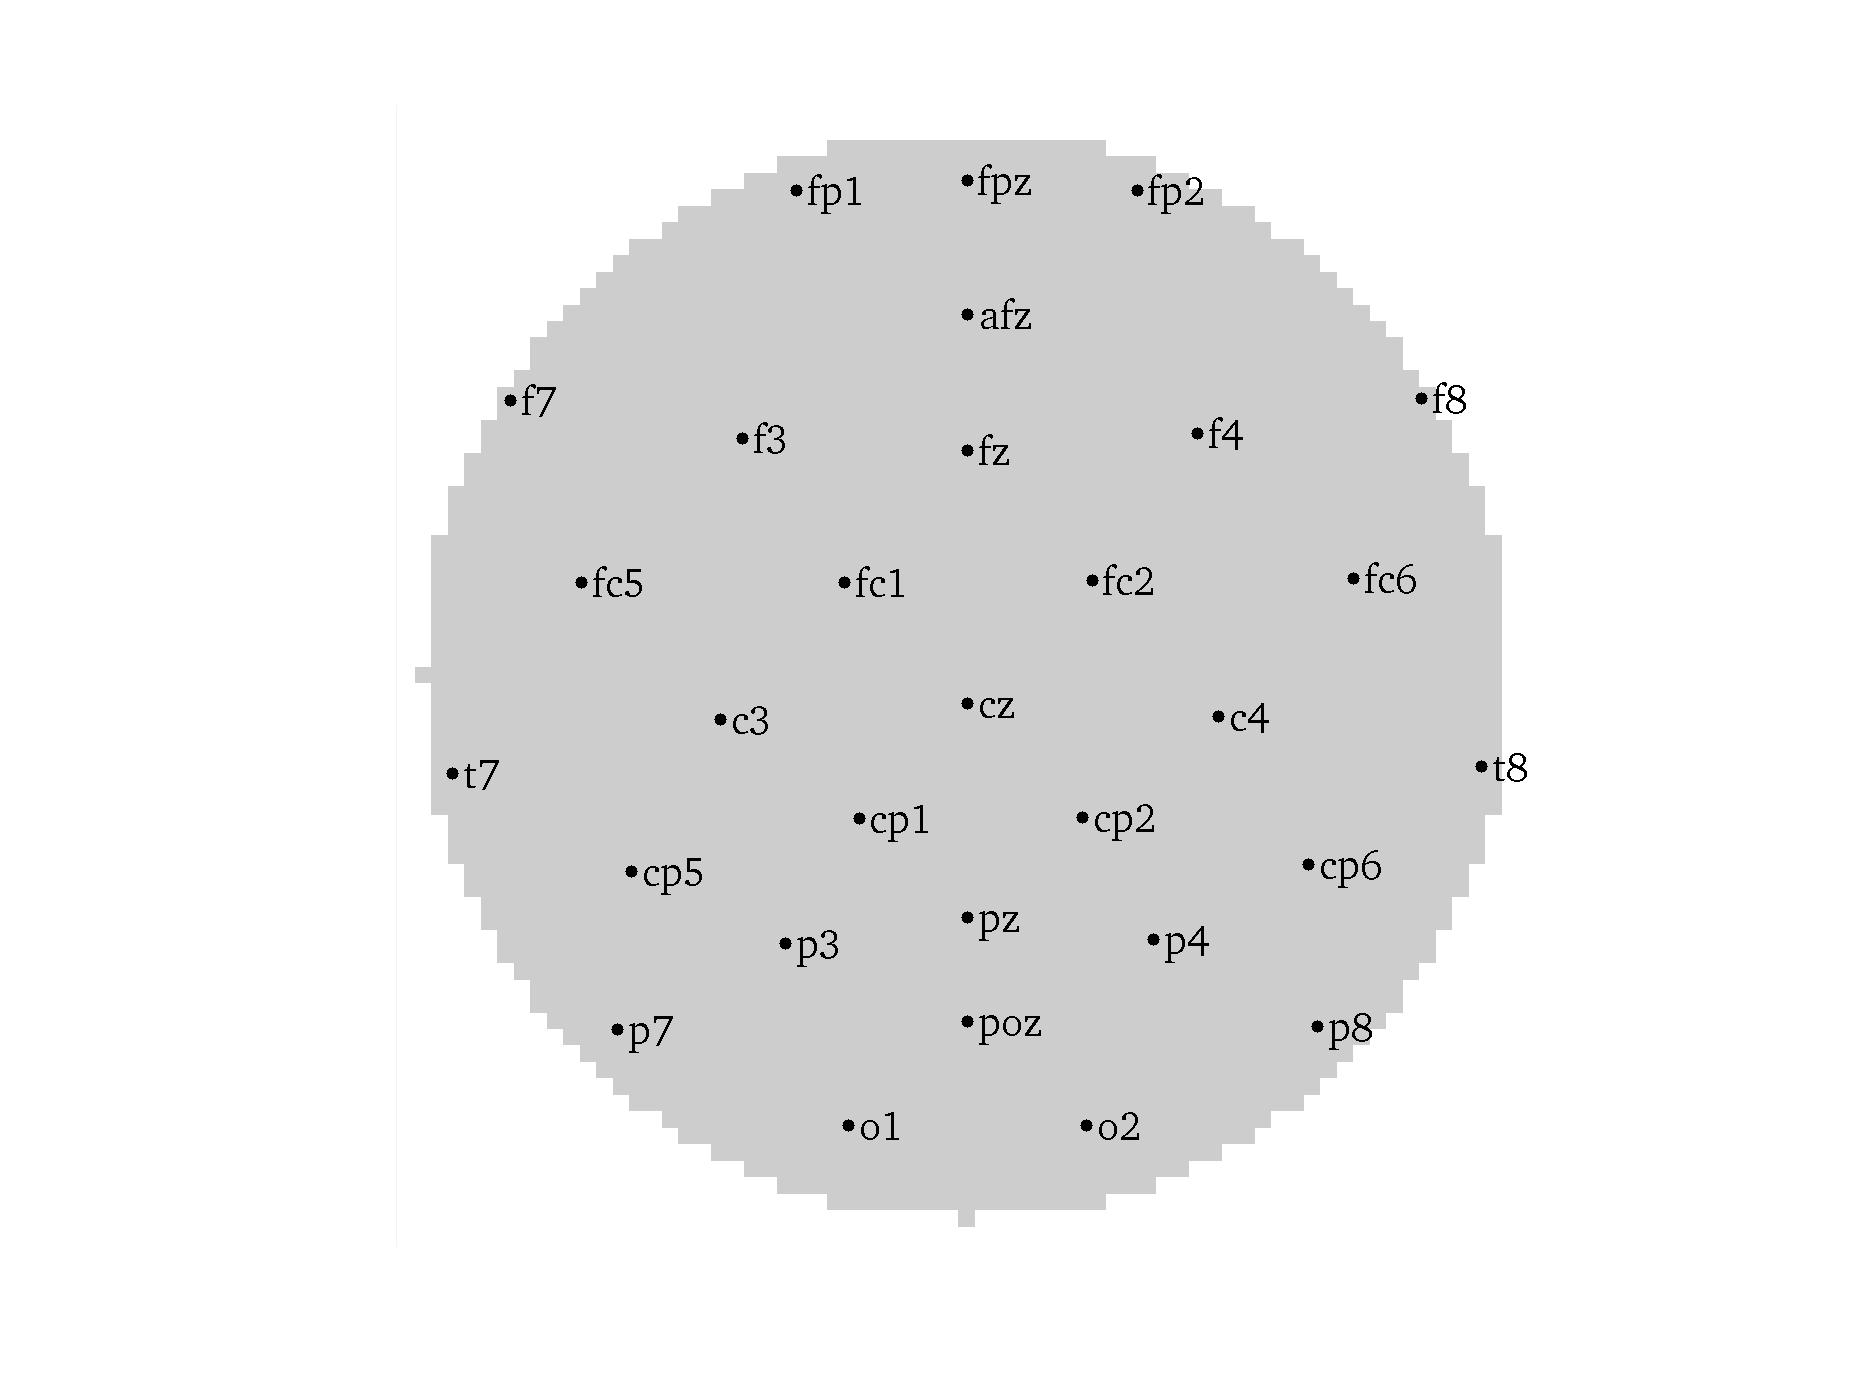

# 6. Inspección de EEG's procesados

Para los cálculos a continuación uso ref https://link.springer.com/content/pdf/10.1007/s10548-008-0054-5.pdf

In [45]:
egg = eegs[1]

Siendo la media $\bar{u}=\frac{1}{c}\sum_{i=1}^{c}{U_{i}}$   donde $c$ es la cantidad total de canales y $U_{i}$ es la medición del i-ésimo canal.

Entonces el *average reference* se calcula $u_i=U_i-\bar{u}$

In [46]:
u_mean = np.mean(egg.dataT(), axis=0)  # axis=0 calcula para cada n-esima muestra
u_mean.shape

(7681,)

In [47]:
u_i = egg.dataT() - u_mean

De acuerdo a la referencia el *Global field power* (GFP) se calcula como 
$GFP(n)=\sqrt{\frac{1}{c}\sum_{i=1}^{c}u_{i}^2}$  y es equivalente al desvio estándar de los electrodos (en un cierto tiempo *t* o muestra *n*).

In [48]:
GFP=np.sqrt(1/30*np.sum(u_i**2,axis=0))

In [49]:
#sx_std=np.std(u_i,axis=0) # coincide con el cálculo de GFP como era previsible

In [50]:
GFP=np.sqrt(1/30*np.sum(u_i**2,axis=0))

defino el tiempo

In [51]:
len(GFP)

7681

In [52]:
t = np.arange(0, 60.005, 1/egg.sfrequency)

In [53]:
len(t)

7681

Las otras figuras de sección previa están ploteadas entre 1 y 4 segundos. Sin embargo se tienen datos durante 60 segundos. La varianza obtenida se dibuja para el tiempo total. 

In [54]:
egg.sfrequency * 150 * 1e-3

19.2

Los picos de GCP se encuentran con la función find_peaks. Para evitar que estén demasiado próximos entre sí se elige el parámetro distancia.
Por ejemplo eligiendo distance=8 y con la frecuencia de muestreo de 128 Hz los picos deberán estar alejados en no menos de 60 ms (aproximadamente).

In [55]:
8/egg.sfrequency

0.0625

In [56]:
peaks, _ = find_peaks(GFP, height=0, prominence=1,distance=8)

valores mínimos y máximos entre picos consecutivos

In [57]:
print("Cantidad de picos de GCP:", len(peaks))
print("El intervalo temporal entre máximos de GCP promedio es:",60/len(peaks),'ms')
print("El intervalo temporal entre máximos de GCP más chico es:",min(np.diff(peaks))/128,'ms')
print("El intervalo temporal entre máximos de GCP más grande es:",max(np.diff(peaks))/128,'ms')

Cantidad de picos de GCP: 588
El intervalo temporal entre máximos de GCP promedio es: 0.10204081632653061 ms
El intervalo temporal entre máximos de GCP más chico es: 0.0625 ms
El intervalo temporal entre máximos de GCP más grande es: 0.234375 ms


In [58]:
plot_GPF(GFP, peaks, t)

El remuestreo se hace con los indices determinados por los picos de GCP

In [59]:
fig,ax=plt.subplots(ncols=1,figsize=(16,4))
plt.step(t[peaks[1:]],np.diff(t[peaks]))

Para cada indice identificados del máximo de GCP se calcula cuanto vale $u_{i}$.

In [60]:
data = np.transpose(u_i[:,peaks])
data.shape

(588, 30)

In [61]:
df = pd.DataFrame(data, columns=mont1020_30.ch_names)
df

Fp1       Fpz       Fp2        AFz        F7         F3        Fz  \
0   -4.453914 -5.909714 -3.259114   4.489386  8.171686  -1.642314 -3.856214   
1   -8.518324 -8.365424 -5.219524   0.609206  7.138376  -9.779324 -9.461324   
2   -7.048393 -3.656193  0.394037   1.949207  6.005307  -2.474393 -2.802993   
3   -8.082705 -9.237505 -6.619105  -1.635105  7.418495 -11.571005 -3.468305   
4    2.909521  1.355621 -3.359879 -12.047979 -6.605179   7.553321  4.378121   
..        ...       ...       ...        ...       ...        ...       ...   
583  6.304197  3.481997 -3.554003  -6.821003 -0.061733   6.292397 -0.282893   
584  7.605601  5.957901  0.092768  -7.192199  1.952701  13.803001  3.672401   
585 -4.338078 -5.390778  0.014819   7.620922 -0.932878  -3.454378  0.576922   
586 -4.594111 -5.317911 -1.967011   2.493889  1.602289 -13.655011 -9.927811   
587 -0.885003  4.580887  6.267787   6.129887 -2.761113  -3.433913 -5.628013   

           F4         F8       FC5  ...       CP2       CP6        P7  \
0    2.556386 -13.645014 -7.136414  ... -7.960414 -3.600014 -3.415414   
1   -1.851224  -6.607924 -5.408824  ... -3.442324 -8.201524 -0.665974   
2    1.431807  -3.724693 -4.930793  ... -1.938193 -0.088720 -3.220293   
3    5.107595  -3.965205 -3.355105  ... -3.234505 -7.527505  1.501695   
4   -0.267739   7.047221  1.510321  ...  0.530161  0.545111  7.243721   
..        ...        ...       ...  ...       ...       ...       ...   
583 -5.052403   1.535697  5.233397  ...  0.247237  1.413697 -1.310903   
584 -0.126559   4.087701  1.363401  ... -0.198919  7.011201 -2.905799   
585 -0.903528  -4.744078 -2.523578  ... -0.198888 -0.946768  2.605322   
586 -2.016811  -4.048011  0.258829  ... -0.999831 -7.506111  6.668989   
587 -8.341313  -0.416553  1.082887  ...  3.629287 -1.106213 -1.371613   

            P3        Pz        P4         P8       POz         O1        O2  
0     4.911186  5.068586 -1.588714   8.196586 -8.075014  11.968986 -7.614514  
1     0.300426  4.944176 -7.577224  16.074976 -6.393524  13.013976 -8.448624  
2     5.090607  1.792107  1.087307   4.879207 -5.167493   8.108907 -6.775693  
3    -0.712865  3.224795 -3.096605  13.138995 -7.513005  10.474995 -7.250605  
4   -10.287979 -6.665379 -0.237289   4.590221  2.827521 -14.161979  9.861821  
..         ...       ...       ...        ...       ...        ...       ...  
583  -5.223303 -6.527403 -5.197203   3.151597  6.632997  -7.238403  8.334297  
584  -6.602599 -6.322299 -0.849039  -7.671599  6.859101  -6.198499  9.464201  
585   7.010922  7.019722  4.134322  -0.338118 -4.557678   8.116822 -6.355478  
586   0.963179  4.163689 -4.671811  10.136989 -7.745211   6.885889 -4.517911  
587   4.938687  7.678087  1.537687  -1.849313  2.572087  -0.185803 -2.069513  

[588 rows x 30 columns]

Hago la misma descomposición de PCA, pero como en el dataframe quedaron en las columnas los nombres de los electrodos entonces primero aplico pca al dataset transpuesto (repito lo que hizo antes la profe).



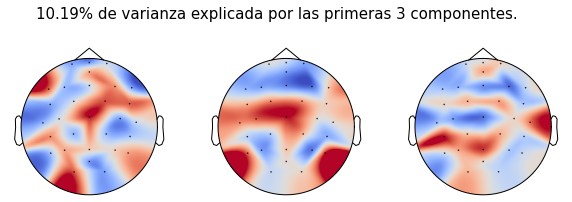

In [120]:
plot_df_pca(df, info_eeg)

In [33]:
#KMeans(n_clusters=6, random_state=0).fit(df)